In [1]:
# System
import os
import sys
import inspect
import tabulate
import time

# Data processing
import numpy as np
import math as m

# Results presentation
from tqdm import tqdm as tqdm
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import data
import models
import utils
import correlation
import regularization

%matplotlib inline

In [2]:
class GlobalArguments():
    
    def __init__(self):
        self.model       = 'ConvFCSimple'
        self.model2      = 'ConvFCSimpleTanh'
        self.dataset     = 'CIFAR100'
        self.data_path   = '../Data/'
        self.batch_size  = 128
        self.num_workers = 4
        self.transform   = 'VGG'
        self.use_test    = True
        self.models_path = 'Checkpoints/'
        self.n_models    = 40
        self.ckpt        = '../Checkpoints/FGE/CIFAR100/ConvFCSimpleTanh/ind_gb/classic/0/fge-200.pt'
        self.boost_ckpts = '../Checkpoints/FGE/CIFAR100/ConvFCSimpleTanh/ind_gb/classic/0/'
        self.device      = 0
args = GlobalArguments()

In [3]:
device = 'cuda:' + str(args.device) if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(device)

In [4]:
if   args.dataset == "CIFAR10":
    num_classes = 10
elif args.dataset == "CIFAR100":
    num_classes = 100
    
architecture = getattr(models, args.model)
architecture2 = getattr(models, args.model2)
model = architecture.base(num_classes=num_classes, **architecture.kwargs)
checkpoint = torch.load(args.ckpt)
model.load_state_dict(checkpoint['model_state'])
model.cuda()

ConvFCSimpleBase(
  (conv_part): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_part): Sequential(
    (0): Linear(in_features=392, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
)

In [5]:
loaders, num_classes = data.loaders_gb(
    args.dataset,
    args.data_path,
    args.batch_size,
    args.num_workers,
    args.transform,
    args.use_test,
    shuffle_train=False,
    logits_generator=regularization.dataset_logits_generator(
        model,
        transform=getattr(getattr(data.Transforms, args.dataset), args.transform).train,
        batch_size=args.batch_size),
)

Files already downloaded and verified
Initial logits :
Shape : torch.Size([50000, 100]) Logits_mean : 0.031111421063542366
Max : 26.348722457885742 Min : -26.508270263671875
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [6]:
# models_list_fge = []
# models_weights  = []
# # indicies = range (690, 1011, 20)
# indicies = [i for i in range (299, 1000, 100)]
# indicies.insert(0, 200)

# for i in tqdm(indicies):
#     model = architecture.base(num_classes=num_classes, **architecture.kwargs)
#     checkpoint = torch.load(args.boost_ckpts + 'fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
#     model.load_state_dict(checkpoint['model_state'])
#     models_list_fge.append(model)
#     models_weights .append(checkpoint['boost_weight'])

100%|██████████| 9/9 [00:00<00:00, 268.75it/s]


In [7]:
models_list_fge = []
models_weights  = []
# indicies = range (690, 1011, 20)
indicies = [i for i in range (399, 1600, 200)]
indicies.insert(0, 200)

for i in tqdm(indicies):
    if i == 200:
        model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    else:
        model = architecture.base(num_classes=num_classes, **architecture2.kwargs)
    checkpoint = torch.load(args.boost_ckpts + 'fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state'])
    models_list_fge.append(model)
    models_weights .append(checkpoint['boost_weight'])

100%|██████████| 8/8 [00:00<00:00, 167.87it/s]


In [8]:
def outputs_target_labels(model, dataloader, device=torch.device('cpu')):
    with torch.no_grad():
        model.to(device)
        target_list = []
        output_list = []
        labels_list = []
        for input, labels, logits in dataloader:
            input  = input .to(device)
            logits = logits.to(device).detach()
            labels = labels.to(device)

            target = utils.one_hot(labels, logits.shape[1]) - F.softmax(logits, dim=1)
            output = model(input)

            output_list.append(output.cpu())
            target_list.append(target.cpu())
            labels_list.append(labels.cpu())

        output_list = torch.cat(output_list, dim=0)
        target_list = torch.cat(target_list, dim=0)
        labels_list = torch.cat(labels_list, dim=0)
    return output_list, target_list, labels_list

def STD(tensor):
    return ((tensor - tensor.mean(dim=0, keepdim=True))**2).mean().sqrt().item()

def target_and_predicted_distributions(model_list, loaders, device=torch.device('cpu')):
    table = {
        'Iter'      : [],
        'Weight'    : [],
        'Trg_mean'  : [],
        'Prd_mean'  : [],
        'Trg_std'   : [],
        'Prd_std'   : [],
        'Mean_L1'   : [],
        'Mean_L2'   : [],
        'Train_acc' : [],
        'Test_acc'  : [],
        'Add_std_tr': [],
        'Add_std_te': [],
    }
    criterion_L2 = torch.nn.MSELoss(reduction='none')
    criterion_L1 = torch.nn.L1Loss(reduction='none')
    
    output_sum_train = 0.
    output_sum_test  = 0.
    
    with torch.no_grad():
        for iter in tqdm(range(len(model_list))):
            model = model_list[0].eval().to(device)
            
            output_train, target_train, labels_train = outputs_target_labels(
                model,
                loaders['train'],
                device=device)
                
            output_test, target_test, labels_test = outputs_target_labels(
                model,
                loaders['test'],
                device=device)
            
            output_sum_train += models_weights[iter] * output_train
            output_sum_test  += models_weights[iter] * output_test
         
            table['Iter'      ].append(iter)
            table['Weight'    ].append(models_weights[iter])
            table['Trg_mean'  ].append(target_test.mean().item())
            table['Prd_mean'  ].append(output_test.mean().item())
            table['Trg_std'   ].append(STD(target_test))
            table['Prd_std'   ].append(STD(output_test))
            table['Mean_L1'   ].append(criterion_L1(output_test, target_test).mean().item())
            table['Mean_L2'   ].append(criterion_L2(output_test, target_test ).mean().item())
            table['Train_acc' ].append(torch.eq(output_sum_train.argmax(dim=1), labels_train).float().mean().item())
            table['Test_acc'  ].append(torch.eq(output_sum_test .argmax(dim=1), labels_test ).float().mean().item())
            table['Add_std_tr'].append(STD(models_weights[iter] * output_train))
            table['Add_std_te'].append(STD(models_weights[iter] * output_test))
  
            loaders['train'].dataset.update_logits(
                models_weights[iter],
                logits_generator=regularization.dataset_logits_generator(
                    model,
                    transform=getattr(getattr(
                            data.Transforms,
                            args.dataset),
                        args.transform).train,
                    batch_size = args.batch_size))
        
            loaders['test'].dataset.update_logits(
                models_weights[iter],
                logits_generator=regularization.dataset_logits_generator(
                    model,
                    transform=getattr(getattr(
                            data.Transforms,
                            args.dataset),
                        args.transform).test,
                    batch_size = args.batch_size))
            
            del model
            del model_list[0]
    return table
            
            
#         regularization.logits_info(dataloader.dataset.logits)

In [9]:
table = target_and_predicted_distributions(models_list_fge, loaders, device=torch.device('cuda'))
print (tabulate.tabulate(table, headers='keys', tablefmt="grid"))

100%|██████████| 8/8 [04:29<00:00, 33.72s/it]

+--------+----------+-------------+--------------+-----------+-------------+-----------+-------------+-------------+------------+--------------+--------------+
|   Iter |   Weight |    Trg_mean |     Prd_mean |   Trg_std |     Prd_std |   Mean_L1 |     Mean_L2 |   Train_acc |   Test_acc |   Add_std_tr |   Add_std_te |
+========+==========+=============+==============+===========+=============+===========+=============+=============+============+==============+==============+
|      0 |  1       | 1.25885e-09 |  0.0296333   | 0.086225  | 3.42379     | 2.88144   | 14.1456     |     0.42784 |     0.4237 |   3.2947     |   3.42379    |
+--------+----------+-------------+--------------+-----------+-------------+-----------+-------------+-------------+------------+--------------+--------------+
|      1 | 17.6585  | 3.47567e-09 |  0.000107922 | 0.0882275 | 0.00117422  | 0.0132166 |  0.0077872  |     0.42824 |     0.4245 |   0.018827   |   0.0207351  |
+--------+----------+-------------+-----

In [10]:
def draw_grapfics(table, filename=None):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    nrows=3, ncols=2,
    figsize=(10, 15))
    
    ax1.plot(table['Iter'], np.array(table['Train_acc']) * 100, marker='o')
    ax1.set_title('Train accuracy')
    ax1.set_xlabel('Iter')
    ax1.set_ylabel('Train accuracy')
    
    ax2.plot(table['Iter'], np.array(table['Test_acc']) * 100, marker='o')
    ax2.set_title('Test accuracy')
    ax2.set_xlabel('Iter')
    ax2.set_ylabel('Test accuracy')
    
    ax3.plot(table['Iter'][1:], table['Mean_L1'][1:], marker='o')
    ax3.set_title('Mean L1 on test')
    ax3.set_xlabel('Iter')
    ax3.set_ylabel('L1')
    
    ax4.plot(table['Iter'][1:], table['Mean_L2'][1:], marker='o')
    ax4.set_title('Mean L2 on test')
    ax4.set_xlabel('Iter')
    ax4.set_ylabel('L2')
    
    ax5.plot(table['Iter'][1:], table['Weight'][1:], marker='o')
    ax5.set_title('Weight in boosting')
    ax5.set_xlabel('Iter')
    ax5.set_ylabel('Weight')
    
    ax6.plot(table['Iter'][1:], table['Add_std_tr'][1:], marker='o')
    ax6.set_title('Added STD')
    ax6.set_xlabel('Iter')
    ax6.set_ylabel('STD')
    
    if filename is not None:
        plt.savefig(filename + '.png')

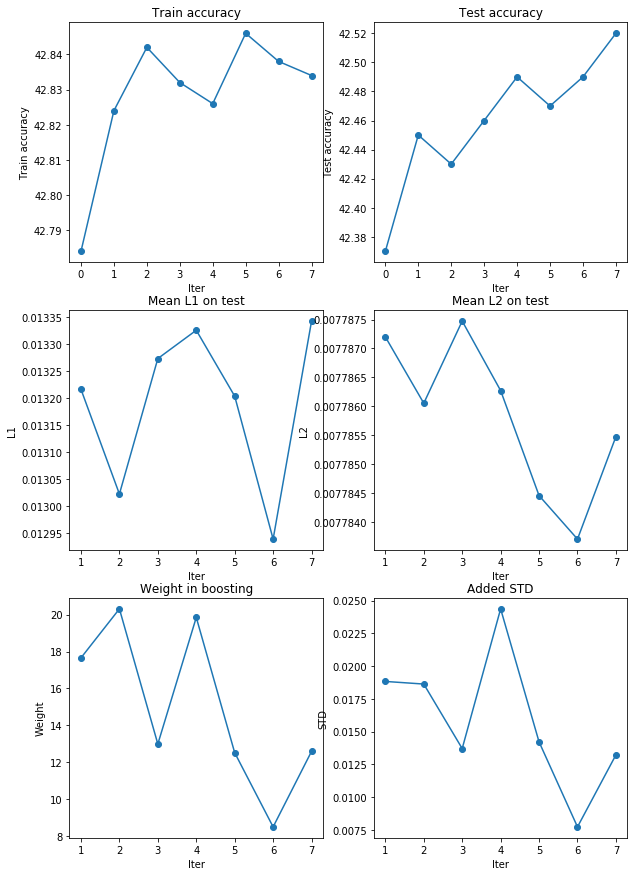

In [11]:
# print ('Lr : 0.01 - 0.0001')
draw_grapfics(table, filename='figures/ConvFC_indGB_0.01-0.0001_200')